In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys
import networkx as nx


#sys.path.append('../prepro/')

# Import the variables from prepro_trans_smote
#from prepro_trans_smote import X_res, y_res




from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score



In [37]:
file_path = '../../data/transactions.pkl'

with open(file_path, 'rb') as file:
    data = pickle.load(file)

# Now `data` holds the contents of the loaded .pkl file
print(data)

        step  customer  age  gender  merchant  category    amount  fraud
0          0       210    4       2        30        12 -0.299276      0
1          0      2753    2       2        30        12  0.016067      0
2          0      2285    4       1        18        12 -0.098742      0
3          0      1650    3       2        30        12 -0.185275      0
4          0      3585    5       2        30        12 -0.019480      0
...      ...       ...  ...     ...       ...       ...       ...    ...
594638   179      1639    3       1        18        12 -0.155832      0
594639   179      3369    4       1        18        12  0.115256      0
594640   179       529    2       1        31         2 -0.138687      0
594641   179      1083    5       2        18        12 -0.210319      0
594642   179      3304    4       1        18        12 -0.098383      0

[594643 rows x 8 columns]


In [38]:
data = pd.read_pickle("../../data/transactions.pkl")

X = data.drop(['fraud'],axis=1)
y = data['fraud']

## RF with Graph features

In [50]:
# Split data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(data.drop(['fraud'], axis=1), data['fraud'], test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42) 

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_valid.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 356785 samples
Validation set size: 118929 samples
Testing set size: 118929 samples


In [51]:
# Function to add graph features
def add_graph_features(df):
    G = nx.from_pandas_edgelist(df, 'customer', 'merchant', create_using=nx.Graph())
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)

    df['degree_centrality'] = df['customer'].map(degree_centrality).fillna(0)
    df['closeness_centrality'] = df['customer'].map(closeness_centrality).fillna(0)
    df['betweenness_centrality'] = df['customer'].map(betweenness_centrality).fillna(0)
    return df

# Apply graph features
X_train = add_graph_features(X_train)
X_valid = add_graph_features(X_valid)
X_test = add_graph_features(X_test)

In [52]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [53]:
# Define the model and parameter grid for GridSearch
model = RandomForestClassifier(random_state=42, verbose=1, class_weight="balanced")
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [8, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Setup the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='recall', verbose=2, n_jobs=-1)
grid_search.fit(X_res, y_res)

# Best model
best_model = grid_search.best_estimator_

# Predictions using the best model
y_pred_valid = best_model.predict(X_valid)
y_pred_test = best_model.predict(X_test)

Fitting 3 folds for each of 81 candidates, totalling 243 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.1min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 1

[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.3min
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time= 1.2min
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 2.4min
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 2.4min
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time= 3.5min
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.4min
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 3.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time= 1.5min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time= 4.4min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time= 2

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:  2.5min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.8s finished


[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.3min
[CV] END max_depth=8, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 3.6min
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time= 2.3min
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time= 1.2min
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time= 1.2min
[CV] END max_depth=8, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time= 2.4min
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time= 2.5min
[CV] END max_depth=8, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time= 3.7min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time= 2.9min
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time= 4.3

In [54]:
# Evaluation on validation and test data
print("Validation Set Classification Report: \n", classification_report(y_valid, y_pred_valid))
print("Validation Set Confusion Matrix: \n", confusion_matrix(y_valid, y_pred_valid))
print("Test Set Classification Report: \n", classification_report(y_test, y_pred_test))
print("Test Set Confusion Matrix: \n", confusion_matrix(y_test, y_pred_test))


Validation Set Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    117536
           1       0.27      0.89      0.42      1393

    accuracy                           0.97    118929
   macro avg       0.64      0.93      0.70    118929
weighted avg       0.99      0.97      0.98    118929

Validation Set Confusion Matrix: 
 [[114262   3274]
 [   156   1237]]
Test Set Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.97      0.99    117512
           1       0.29      0.88      0.43      1417

    accuracy                           0.97    118929
   macro avg       0.64      0.93      0.71    118929
weighted avg       0.99      0.97      0.98    118929

Test Set Confusion Matrix: 
 [[114413   3099]
 [   164   1253]]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    1.1s finished


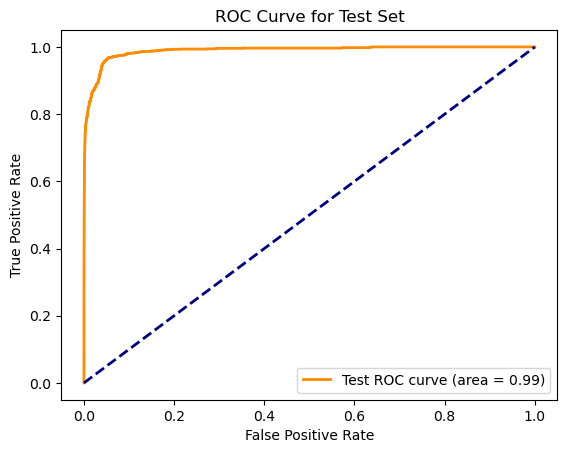

In [56]:
# ROC Curve for the test set
fpr_test, tpr_test, _ = roc_curve(y_test, best_model.predict_proba(X_test)[:,1])
roc_auc_test = auc(fpr_test, tpr_test)
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Test Set')
plt.legend(loc="lower right")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished


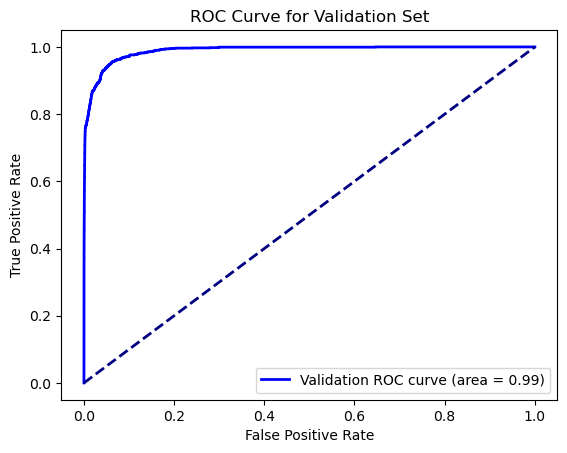

In [57]:
# ROC Curve for the validation set
fpr_valid, tpr_valid, _ = roc_curve(y_valid, best_model.predict_proba(X_valid)[:,1])
roc_auc_valid = auc(fpr_valid, tpr_valid)
plt.figure()
plt.plot(fpr_valid, tpr_valid, color='blue', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_valid)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Validation Set')
plt.legend(loc="lower right")
plt.show()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.9s finished


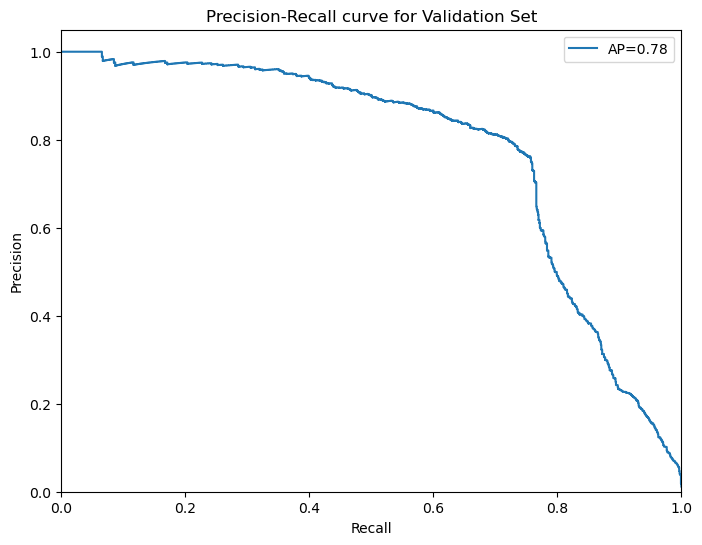

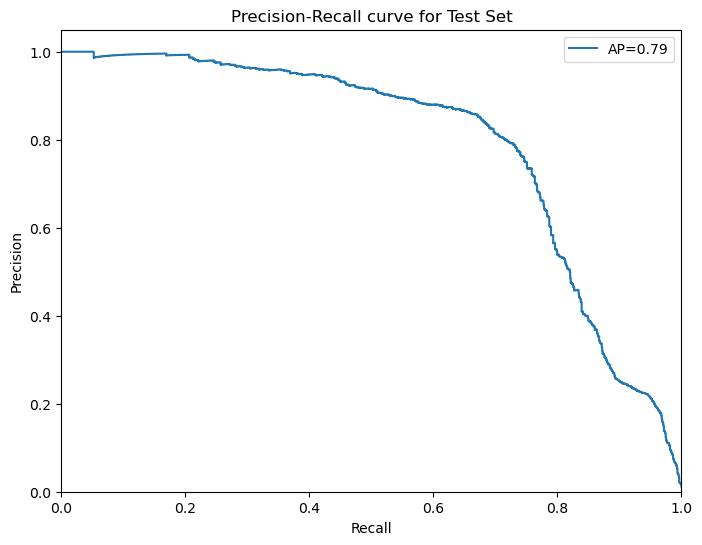

In [58]:
def plot_precision_recall_curve(y_true, y_scores, set_name):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    average_precision = average_precision_score(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.step(recall, precision, where='post', label=f'AP={average_precision:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall curve for {set_name}')
    plt.legend(loc='upper right')
    plt.show()

# Generate scores for precision-recall curves
y_scores_valid = best_model.predict_proba(X_valid)[:, 1]
y_scores_test = best_model.predict_proba(X_test)[:, 1]

# Plot precision-recall curves
plot_precision_recall_curve(y_valid, y_scores_valid, 'Validation Set')
plot_precision_recall_curve(y_test, y_scores_test, 'Test Set')
